In [1]:
import numpy as np
#import process_edited as pce
import process_GQ as pce
import autoencoder as ae
import diffusion as diff
import TabDDPMdiff as TabDiff
import pandas as pd
import torch
import os
import time
import numpy as np

In [2]:
os.getcwd()

'C:\\Users\\Namjoon Suh\\Tabular_Data'

In [ ]:
strings_set = {'abalone', 'adult', 'Churn_Modelling','faults', 'indian_liver_patient', 
               'insurance', 'News', 'Obesity', 'Shoppers', 'Titanic', 'wilt', 'Bean', 'nursery', 'Magic', 'HTRU'}
Model = 'AutoDiff'

for string in strings_set:
    filename = f'Real_Data/{string}.csv'
    # Read dataframe
    print(filename)
    real_df = pd.read_csv(filename)
    #real_df = real_df.drop('url', axis=1)
    
    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_df, threshold)

    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 10000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = 50

    ds = ae.train_autoencoder(real_df, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    ################################################################################################################
    # diffusion hyper-parameters
    diff_n_epochs = 10000 #@param {'type':'integer'}
    hidden_dims = (256, 512, 1024, 512, 256) #@param {type:"raw"}
    converted_table_dim = latent_features.shape[1] #@param {'type':'integer'}
    sigma = 20  #@param {'type':'integer'} 
    num_batches_per_epoch = 50 #@param {'type':'number'}
    batch_size = 50 #@param {'type':'integer'}
    T = 100  #@param {'type':'integer'}

    score = TabDiff.train_diffusion(latent_features, T, eps, sigma, lr, \
                        num_batches_per_epoch, maximum_learning_rate, weight_decay, diff_n_epochs, batch_size)

    ################################################################################################################
    # Generate 10 fake tabular datasets
    T = 300; N = latent_features.shape[0]; P = latent_features.shape[1]
    
    time_duration = []
    
    for i in range(1,11):
        start_time = time.time()

        sample = diff.Euler_Maruyama_sampling(score, T, N, P, device)

        end_time = time.time()
        duration = end_time - start_time

        time_duration.append(duration)

        gen_output = ds[0](sample, ds[2], ds[3])
        syn_df = pce.convert_to_table(real_df, gen_output, threshold)
        #syn_df['age'] = syn_df['age'].astype(int)

        output_directory = os.getcwd()+f'/Synthetic_Data/{Model}/{string}/'
        filename = f'{Model}_{string}{i}.csv'
        sampling_time = f'{Model}_{string}_sampling_time.csv'

        output_file = os.path.join(output_directory, filename)
        time_file = os.path.join(output_directory, sampling_time)

        syn_df.to_csv(output_file, index=False)

        df = pd.DataFrame(time_duration, columns=[f'{Model}_{string}_sampling_time'])
        df.to_csv(time_file, index=False)

Real_Data/HTRU.csv


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\Namjoon Suh\Tabular_Data\TabDDPMdiff.py:270: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)
C:\Users\Namjoon Suh\Tabular_Data\TabDDPMdiff.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


In [ ]:
import numpy as np
import pandas as pd

string = 'HTRU'
Model = 'AutoDiff'

filename = f'Real_Data/{string}.csv'
real_df = pd.read_csv(filename)
syn_filename = f'Synthetic_Data/{Model}/{string}/{Model}_{string}{3}.csv'

syn_df = pd.read_csv(syn_filename)

syn_df

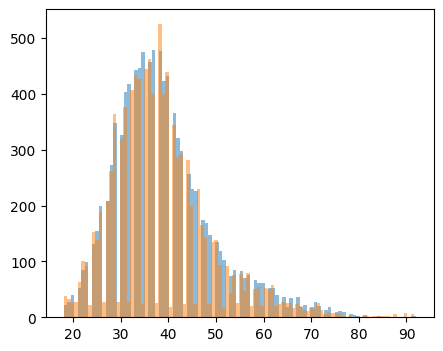

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#syn_df = pd.read_csv('AutoDiff_adult7.csv')
# Plot Weight the categorical variables
col = 'Age'

#gen_output = ds[0](ds[1], ds[2], ds[3])
#syn_df = pce.convert_to_table(real_df, gen_output, threshold)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
axes.hist(real_df[col], bins=100, alpha=0.5, label='Real')
axes.hist(syn_df[col], bins=100, alpha=0.5, label='Auto-Diff')
plt.show()

In [ ]:
real_df[col]

In [127]:
import zipfile
import shutil
path = "C:\\Users\\Namjoon Suh\\Tabular_Data\\Synthetic_Data\\"
zip_file_name = "TabAutoDiff.zip"

with zipfile.ZipFile(zip_file_name, "w") as zip_file:
    for root, dirs, files in os.walk(path):
        for file in files:
            zip_file.write(os.path.join(root, file))

In [128]:
from IPython.display import FileLink
display(FileLink(zip_file_name))

C:\Users\Namjoon Suh\Tabular_Data\TabAutoDiff.zip

In [ ]:
import os
strings_set = {'abalone', 'adult', 'Bean', 'Churn_Modelling','faults', 'HTRU', 'indian_liver_patient', 
               'insurance', 'Magic', 'News', 'nursery', 'Obesity', 'Shoppers', 'Titanic', 'wilt'}

for string in strings_set:
    output_directory = f'Synthetic_Data/TabDDPM/{string}'
    os.makedirs(output_directory)